## Implementing Contrastive Layer-wise Relevance Propagation with Innvestigate

Contrastive Layer-wise Relevance Propagation[1] or CLRP is a modification of standard Layer-wise Relevance Propagation[2] (LRP) with the goal of making the output (more) class discriminative. This notebook will use the LRP library Innvestigate[3] to attempt to implement CLRP.

A general overview of CLRP is as follows:

 1. Given an output neuron $y_j$ which represent concept $O$ we try to construct a *dual* virtual concept $\overline O$ which represents the opposite concept of $O$.  
 2. This concept $\overline O$ can be represented in two different ways:  
   A. CLRP1: The concept is represented by the selected classes with weights $\overline W = \{W^1, W^2, ..., W^{L-1}, W^L_{-j}\}$. Here $W_{-j}$ means the weights connected to the output layer excluding the $j$-th neuron.    
   B. CLRP2: The concept is represented by the selected classes with weights $\overline W = \{W^1, W^2, ..., W^{L-1}, -1 * W^L_{j}\}$. Which means all the weights are the same, except for the last layer where the weights to neuron $j$ are negated.  
 4. (?) The score $S_{y_j}$ of target class is uniformly redistributted to other classes.  
 5. $R_{\text{LRP}} = f_{\text{LRP}}(X, W, S_{y_j})$
 6. Given the same input example $X$ LRP generates an explanation $R_{\text{dual}} = f_{\text{LRP}}(X, \overline W, S_{y_j})$ for the dual concept.  
 7. Then CLRP is defined as follows: $R_{\text{CLRP}} = \max(0, R - R_{\text{dual}})$
 
 _________
 
 Here are some results from the CLRP paper which shows a very clear class discrimitative property. These results are from using VGG16 pre-trained on imagenet and applying the $z^\beta$-rule in the first convolution layer and for all the other convulutional layers the $z^+$-rule. For more details read the paper.
 
 ![results](https://user-images.githubusercontent.com/22032197/53959686-a6670000-40e4-11e9-8de2-ce13d038f5c1.png)
 
 _________
 
 [1] @article{gu2018understanding,
  title={Understanding Individual Decisions of CNNs via Contrastive Backpropagation},
  author={Gu, Jindong and Yang, Yinchong and Tresp, Volker},
  journal={arXiv preprint arXiv:1812.02100},
  year={2018}
}

 [2] @article{bach-plos15,
    author = {Bach, Sebastian AND Binder, Alexander AND Montavon, Gr{\'e}goire AND Klauschen, Frederick AND M{\"u}ller, Klaus-Robert AND Samek, Wojciech},
    journal = {PLoS ONE},
    publisher = {Public Library of Science},
    title = {On Pixel-Wise Explanations for Non-Linear Classifier Decisions by Layer-Wise Relevance Propagation},
    year = {2015},
    month = {07},
    volume = {10},
    url = {http://dx.doi.org/10.1371%2Fjournal.pone.0130140},
    pages = {e0130140},
    number = {7},
    doi = {10.1371/journal.pone.0130140}
}

 [3] https://github.com/albermax/innvestigate/



In [1]:
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import preprocessing

import innvestigate
from innvestigate import utils as iutils
import innvestigate.utils.visualizations as ivis

%matplotlib inline

Using TensorFlow backend.


## Helper Functions

In [2]:
def load_image(path):
    img_path = path
    img = preprocessing.image.load_img(img_path, target_size=(224, 224))
    x = preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


def rescale(img):
    if True:
        return (img - img.min()) / (img.max() - img.min())
    else:
        return ivis.heatmap(img)


def clrp(R, R_dual):
    return np.clip(R - R_dual, a_min=0, a_max=None)


def plot_images(imgs, suptitle=None, titles=None):
    n = len(imgs)
    if titles is None or len(titles) != n:
        titles = [""] * n
    
    fig, axes = plt.subplots(1, n)
    fig.set_figwidth(5 * n)
#     fig.set_figheight(10)
    
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
    
    for ax, img, t in zip(axes, imgs, titles):
        ax.set_title(t)
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

def plot_CLRP(R, R_dual, title=None):
    imgs = [rescale(R[0]), rescale(R_dual[0]), rescale(clrp(R, R_dual)[0])]
    titles = ["R", "R_dual", "CLRP"]
    plot_images(imgs, title, titles)

## Load VGG16 and images

In [3]:
model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

imgnet_class2idx = {
    "tusker": 101,
    "zebra": 340,
    "indian_elephant": 385,
    "african_elephant": 386,
}
imgnet_idx2class = {v: k for k, v in imgnet_class2idx.items()}

if True:
    imgz, imgz_pp = load_image("./data/zebra.jpg")
    imge, imge_pp = load_image("./data/elephant.jpg")
    imgze, imgze_pp = load_image("./data/zebra_and_elephant.jpg")
else:
    imgz, imgz_pp = load_image("./data/zebra2.png")
    imge, imge_pp = load_image("./data/elephant2.png")
    imgze, imgze_pp = load_image("./data/zebra_and_elephant2.png")

img, img_pp = imgze, imgze_pp

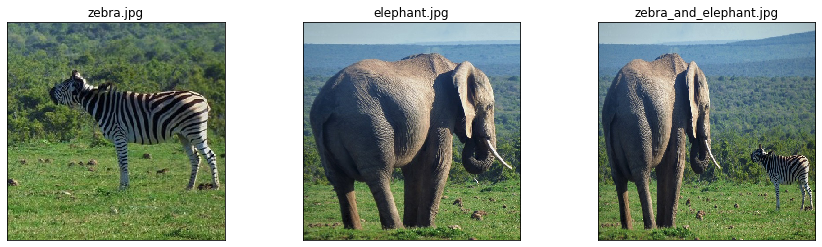

In [4]:
plot_images([imgz, imge, imgze], titles=["zebra.jpg", "elephant.jpg", "zebra_and_elephant.jpg"])

## Preparing an LRP model and analyze an image

Unfortunatly, as far as I know, Innvestigate doesn't support using different rules for different layers, so I use a rule that shows decent results when applied to all layers.

In [5]:
model_wo_sm = iutils.keras.graph.model_wo_softmax(model)

rule = "lrp.sequential_preset_a"

params = {}
analyzer = innvestigate.create_analyzer(rule, model_wo_sm, **params, neuron_selection_mode="index")

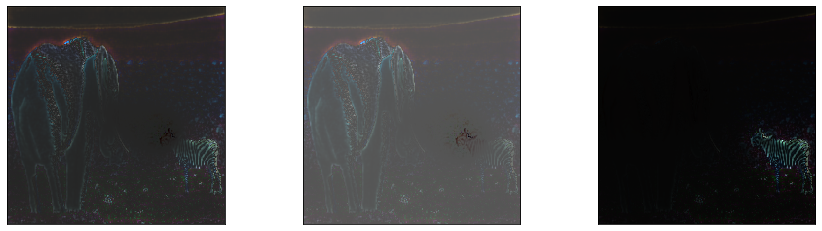

In [6]:
R_elephant = analyzer.analyze(img_pp, imgnet_class2idx["african_elephant"])
R_tusker = analyzer.analyze(img_pp, imgnet_class2idx["tusker"])
R_zebra = analyzer.analyze(img_pp, imgnet_class2idx["zebra"])
plot_images([rescale(R_elephant[0]), rescale(R_tusker[0]), rescale(R_zebra[0])])

## Conservativity

CLRP assumes that the analyzer is conservative. The generated saliency map is conservative if the sum of assigned relevance values of input neurons is equal to the score of the class-specific neuron before the soft-max function:  
 $\sum^n_{i=1}r_i = S_{y_j}$

In [7]:
def conservation(H, Y, error=0.5):
    R = H.sum()
    c = np.abs((R - Y)/(Y+1e-9)).max()
    print(c)
    return 0. <= c <= error

pred = model_wo_sm.predict(img_pp)
y = pred[0][imgnet_class2idx["african_elephant"]]

conservation(R_elephant, y)

0.2857270128000847


True

## CLRP

We add a linear dense layer to the model and set the weights manually so that the outputs represent the *concept* and the *not concept*

In [8]:
replace_last_layer = True
if replace_last_layer:
    o = keras.layers.Dense(2, use_bias=False, activation='linear', name='concept', trainable=False)(model_wo_sm.layers[-2].output)
 
    def get_weights(output_size, idx, method="CLRP1"):
        W_old = model.layers[-1].get_weights()[0]
        W = np.zeros((W_old.shape[0], 2))

        if method == "CLRP1":
            # concept weights
            W[:, 0] = W_old[:, idx]
            # not concept weights
            W[:, 1] = W_old.sum(axis=1)-W_old[:, idx]
        elif method == "CLRP2":
            # concept weights
            W[:, 0] = W_old[:, idx]
            # not concept weights
            W[:, 1] = -W_old[:, idx]
        else:
            raise Exception("Unknown method")

        return W
else:
    o = keras.layers.Dense(2, use_bias=False, activation='linear', name='concept', trainable=False)(model_wo_sm.output)

    def get_weights(output_size, idx, method="CLRP1"):
        W = np.zeros((output_size, 2))

        if method == "CLRP1":
            # concept weights
            W[idx, 0] = 1
            # not concept weights
            W[:, 1] = 1
            W[idx, 1] = 0
        elif method == "CLRP2":
            # concept weights
            W[idx, 0] = 1
            # not concept weights
            W[idx, 1] = -1
        else:
            raise Exception("Unknown method")

        return W    
    
cmodel = keras.models.Model(inputs=model.input, outputs=o, name='concept_model')
cmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
canalyzer = innvestigate.create_analyzer(rule, cmodel, **params, neuron_selection_mode="index")

In [9]:
def analyze_concept(cmodel, idx, img_pp, rule, params):
    _, s = cmodel.layers[-2].output_shape
    
    W = get_weights(s, idx)
    cmodel.get_layer("concept").set_weights([W])
    
    R = canalyzer.analyze(img_pp, 0)
    R_dual = canalyzer.analyze(img_pp, 1)
    
    return R, R_dual

In [10]:
for c in ["african_elephant", "tusker", "zebra"]:
    print("Class probability", c, model.predict(img_pp)[0, imgnet_class2idx[c]])

Class probability african_elephant 0.0010689034
Class probability tusker 0.00014234822
Class probability zebra 0.9868057


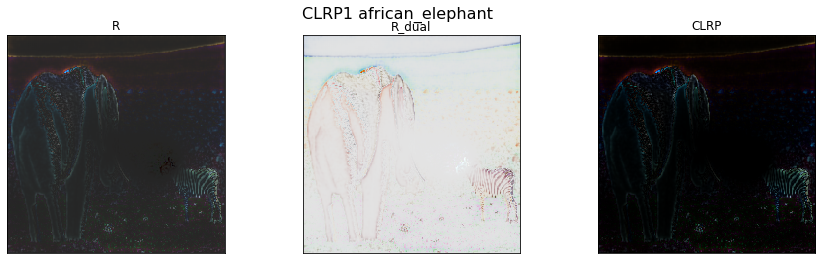

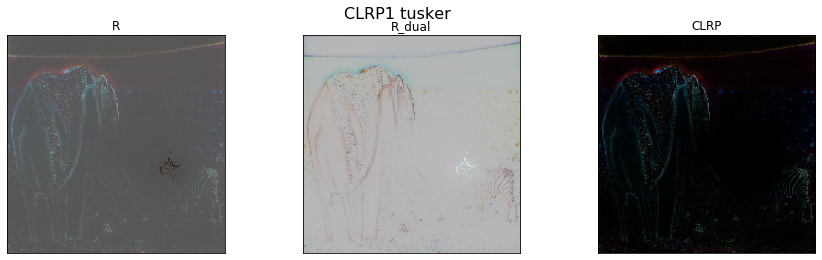

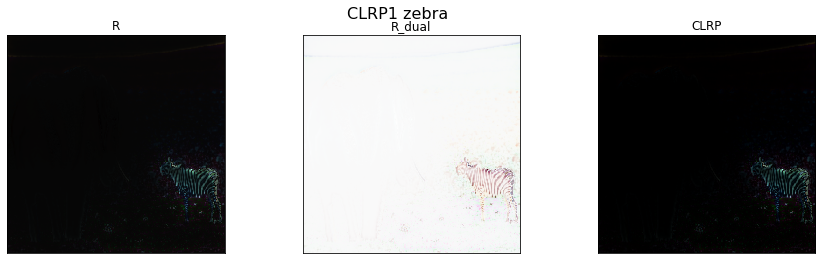

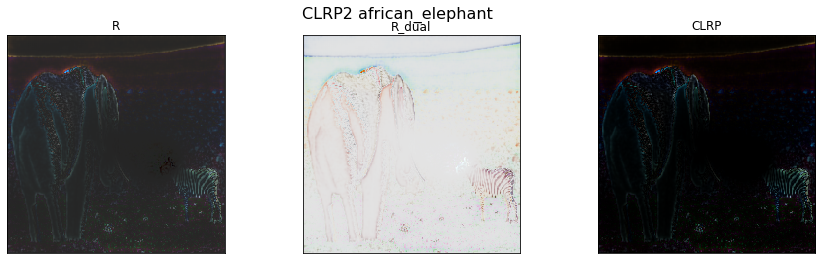

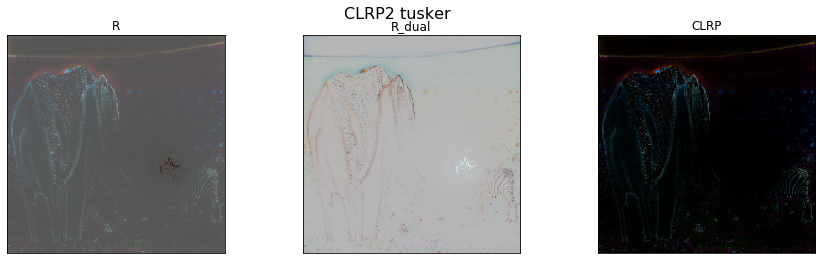

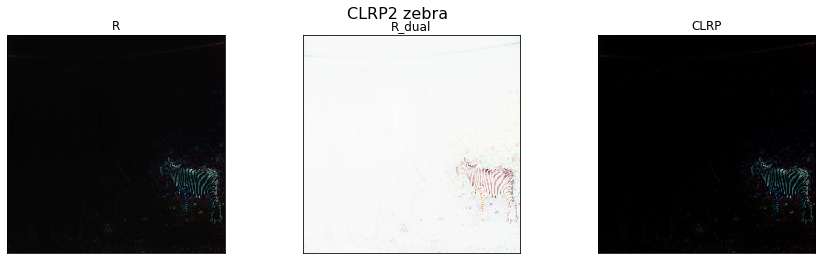

In [11]:
for variante in ["CLRP1", "CLRP2"]:
    for c in ["african_elephant", "tusker", "zebra"]:
        R, R_dual = analyze_concept(cmodel, imgnet_class2idx[c], img_pp, rule, params)
        plot_CLRP(R, R_dual, title=variante+" "+c)

## Conclusion

I Couldn't reproduce the results from the CLRP paper. If you have any remarks of what went wrong, please notify me.